# Packages

### Install necessary packages

In [ ]:
 !pip install tensorflow_addons
 !pip install pyyaml h5py 

     |████████████████████████████████| 706kB 11.0MB/s 


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from pandas.tseries.offsets import MonthEnd

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


from google.colab import drive
from datetime import datetime

device_name = tf.test.gpu_device_name()

print(device_name)

/device:GPU:0


### Show if GPU is available

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#Data


###Import price data from drive

In [ ]:
drive.mount('/content/drive')

prices = pd.read_csv('/content/drive/MyDrive/power_market_paper/day_ahead_prices_05_01_2015__04_02_2020 edited.csv')

# separate on comma
prices = prices["MTU (CET);Day-ahead Price [EUR/MWh]"].str.split(';', expand=True)
prices = prices.rename(columns={0:"date_prices", 1:"price"})
prices.price = prices.price.astype(float)

print('\n')
print("Imported price data with corresponding time and date:")
prices

Mounted at /content/drive


Imported price data with corresponding time and date:


,date_prices,price
0,05.01.2015 00:00 - 05.01.2015 01:00,36.56
1,05.01.2015 01:00 - 05.01.2015 02:00,34.94
2,05.01.2015 02:00 - 05.01.2015 03:00,32.19
3,05.01.2015 03:00 - 05.01.2015 04:00,28.05
4,05.01.2015 04:00 - 05.01.2015 05:00,28.04
...,...,...
44563,04.02.2020 19:00 - 04.02.2020 20:00,42.07
44564,04.02.2020 20:00 - 04.02.2020 21:00,39.75
44565,04.02.2020 21:00 - 04.02.2020 22:00,30.13
44566,04.02.2020 22:00 - 04.02.2020 23:00,30.36


### Import Weather Data via API

In [ ]:
## WEATHER API CODE##

print("Uncomment the text in this cell to automatically scrape the data from the worldweatheronline API \n The data can also be loaded from the google drive by running the next code block")
# contents = []
# #retreive start and end dates for months to download data from   
# for beg in pd.date_range('2015-01-01', '2020-02-05', freq='MS'):
#     #print(beg.strftime("%Y-%m-%d"), (beg + MonthEnd(1)).strftime("%Y-%m-%d"))
#     start_date = beg.strftime("%Y-%m-%d")
#     end_date = (beg + MonthEnd(1)).strftime("%Y-%m-%d")
#     #print(start_date)
#     url = "http://api.worldweatheronline.com/premium/v1/past-weather.ashx?key=4d9549abf4af4713967110506211003&q=Mons&format=json&date={start_date}&enddate={end_date}&includelocation=yes".format(start_date = start_date, end_date = end_date)
#     content = urllib.request.urlopen(url).read()
#     content = pd.read_json(content)
#     weather_normalized = pd.json_normalize(content.to_dict()['data'], record_path=['weather','hourly'], meta=[['weather', 'date']])
#     contents.append(weather_normalized)

# concat months
# df = pd.concat(contents, axis=0)
# pd.set_option("display.max_rows", 10000, "display.max_columns", 10)

# reset index
# df = df.reset_index()



Uncomment the text in this cell to automatically scrape the data from the worldweatheronline API 
 The data can also be loaded from the google drive by running the next code block


### Import weather data from drive 

In [ ]:
## import weather data from drive ##
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/power_market_paper/weather data from api 2015-01-05 to 2020-02-05.csv')

print('\n')
print('The loaded dataset:')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The loaded dataset:


,Unnamed: 0,index,time,tempC,tempF,windspeedMiles,windspeedKmph,winddirDegree,winddir16Point,weatherCode,weatherIconUrl,weatherDesc,precipMM,precipInches,humidity,visibility,visibilityMiles,pressure,pressureInches,cloudcover,HeatIndexC,HeatIndexF,DewPointC,DewPointF,WindChillC,WindChillF,WindGustMiles,WindGustKmph,FeelsLikeC,FeelsLikeF,uvIndex,weather.date
0,0,0,0,0,32,7,11,223,SW,143,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Mist'}],0.0,0.0,95,2,1,1037,31,18,0,32,-1,30,-4,25,15,23,-4,25,1,2015-01-01
1,1,1,300,-1,31,10,15,196,SSW,113,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Clear'}],0.0,0.0,94,10,6,1035,31,16,-1,31,-2,29,-5,22,20,33,-5,22,1,2015-01-01
2,2,2,600,-1,30,11,18,203,SSW,113,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Sunny'}],0.0,0.0,94,10,6,1036,31,13,-1,30,-2,29,-6,21,23,37,-6,21,2,2015-01-01
3,3,3,900,-1,31,13,21,202,SSW,113,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Sunny'}],0.0,0.0,91,10,6,1036,31,8,-1,31,-2,29,-6,21,24,39,-6,21,2,2015-01-01
4,4,4,1200,3,37,15,25,209,SSW,113,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Sunny'}],0.0,0.0,74,10,6,1035,31,6,3,37,-1,30,-2,28,22,36,-2,28,2,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15083,15083,227,900,9,48,24,39,188,S,119,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Cloudy'}],0.0,0.0,84,10,6,991,30,81,9,48,6,43,5,40,36,57,5,40,2,2020-02-29
15084,15084,228,1200,9,49,30,48,209,SSW,119,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Cloudy'}],0.1,0.0,82,5,2,989,30,94,9,49,6,43,5,40,41,66,5,40,2,2020-02-29
15085,15085,229,1500,7,45,23,37,234,SW,266,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Light drizzle'}],0.6,0.0,78,7,4,992,30,69,7,45,3,38,2,36,32,52,2,36,2,2020-02-29
15086,15086,230,1800,5,41,16,26,226,SW,293,[{'value': 'http://cdn.worldweatheronline.com/...,[{'value': 'Patchy light rain'}],0.3,0.0,75,10,6,994,30,24,5,41,1,33,0,33,27,44,0,33,1,2020-02-29


### Combine Price and Weather Data

In [ ]:


# Code below was used for saving the weatherdata to google drive
## below for saving ##
#from google.colab import files
#df.to_csv('weather data from api 2015-01-05 to 2020-02-05.csv') 
#files.download('weather data from api 2015-01-05 to 2020-02-05.csv')
## above for saving ##

#The weather features we used:
df = df[['weather.date', 'time', "windspeedKmph", "cloudcover"]]

# change layout of date and time and convert into datetime type
# https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime
df['time'] = df['time'].astype(str).str.replace('0','')
df = df.replace(r'^\s*$', '0', regex=True)
df['time'] = df['time'].apply(lambda x: '{0:0>2}'.format(x))
df["date"] = df["weather.date"] + ' ' + df["time"]
df['date'] = pd.to_datetime(df['date'], format= "%Y-%m-%d %H")

# change column order
df = df[['date', 'windspeedKmph', 'cloudcover']]

# convert strings to floats
df.windspeedKmph = df.windspeedKmph.astype(float)
df.cloudcover = df.cloudcover.astype(float)

# interpolate
df = df.set_index('date').resample('H').asfreq()
df = df.interpolate()
df = df.reset_index()

# delete leading and trailing days
start_days = 4 * 24
end_days = 25 * 24 - 2
df.drop(df.head(start_days).index, inplace=True)
df.drop(df.tail(end_days).index,inplace=True)
df = df.reset_index()

df = pd.concat([df, prices], axis=1).drop('date_prices', axis=1).drop('index', axis=1)

df


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,date,windspeedKmph,cloudcover,price
0,2015-01-05 00:00:00,12.000000,29.000000,36.56
1,2015-01-05 01:00:00,13.000000,32.000000,34.94
2,2015-01-05 02:00:00,14.000000,35.000000,32.19
3,2015-01-05 03:00:00,15.000000,38.000000,28.05
4,2015-01-05 04:00:00,15.000000,32.333333,28.04
...,...,...,...,...
44563,2020-02-04 19:00:00,11.666667,69.666667,42.07
44564,2020-02-04 20:00:00,11.333333,52.333333,39.75
44565,2020-02-04 21:00:00,11.000000,35.000000,30.13
44566,2020-02-04 22:00:00,11.000000,35.000000,30.36


### One hot encoding

In [ ]:
## one hot encoding hours, weekdays, months, monthdays
# https://stackoverflow.com/questions/46607306/python-numpy-and-pandas-transforming-timestamp-data-into-one-hot-encoding
# create dictionary for map
a = dict(zip(pd.date_range('2010-01-01', '2010-01-01 23:59:39', freq='H').time, range(24)))
# for one hot encoding use get_dummies
df_hourly = pd.get_dummies(df['date'].dt.time.map(a)).reindex(columns=range(24), fill_value=0)
df_weekdaily = pd.get_dummies(df['date'].dt.weekday).reindex(columns=range(7), fill_value=0)
df_monthly = pd.get_dummies(df['date'].dt.month - 1).reindex(columns=range(12), fill_value=0)
df_monthdaily = pd.get_dummies(df['date'].dt.day - 1).reindex(columns=range(31), fill_value=0)
#concatenate hourly and daily one hot encoding dataframes
df = pd.concat([df, df_hourly, df_weekdaily, df_monthly, df_monthdaily], axis=1)
#concatenate weather and price data

df

,date,windspeedKmph,cloudcover,price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,0,1,2,3,4,5,6,7,8,9,10,11,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,2015-01-05 00:00:00,12.000000,29.000000,36.56,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2015-01-05 01:00:00,13.000000,32.000000,34.94,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2015-01-05 02:00:00,14.000000,35.000000,32.19,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2015-01-05 03:00:00,15.000000,38.000000,28.05,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2015-01-05 04:00:00,15.000000,32.333333,28.04,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44563,2020-02-04 19:00:00,11.666667,69.666667,42.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44564,2020-02-04 20:00:00,11.333333,52.333333,39.75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44565,2020-02-04 21:00:00,11.000000,35.000000,30.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44566,2020-02-04 22:00:00,11.000000,35.000000,30.36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Scaling  

In [ ]:
## scaling ##
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Only scale the values that are not one-hot-encoded
df_to_scale = df[['windspeedKmph', 'cloudcover', 'price']]
print(df_to_scale)

scaler = scaler.fit(df_to_scale)
df[['windspeedKmph', 'cloudcover', 'price']] = scaler.transform(df_to_scale)

print(df)

print(scaler.mean_)
print(scaler.var_)

# Warning! If scaler.var_ is equal to [1., 1., 1.], you have scaled too many times --> rerun loading the data and scale again, because this will affect the results

       windspeedKmph  cloudcover  price
0          12.000000   29.000000  36.56
1          13.000000   32.000000  34.94
2          14.000000   35.000000  32.19
3          15.000000   38.000000  28.05
4          15.000000   32.333333  28.04
...              ...         ...    ...
44563      11.666667   69.666667  42.07
44564      11.333333   52.333333  39.75
44565      11.000000   35.000000  30.13
44566      11.000000   35.000000  30.36
44567      11.000000   35.000000  36.70

[44568 rows x 3 columns]
                     date  windspeedKmph  cloudcover     price  ...  27  28  29  30
0     2015-01-05 00:00:00      -0.458580   -0.585353 -0.328543  ...   0   0   0   0
1     2015-01-05 01:00:00      -0.334706   -0.498708 -0.400485  ...   0   0   0   0
2     2015-01-05 02:00:00      -0.210832   -0.412062 -0.522608  ...   0   0   0   0
3     2015-01-05 03:00:00      -0.086958   -0.325417 -0.706458  ...   0   0   0   0
4     2015-01-05 04:00:00      -0.086958   -0.489080 -0.706902  ...   0   

### Dividing into Train & Test Set

In [ ]:
df_small = np.array(df.iloc[:, 1:]) # possibility to adapt the first dimension of the slice to use a smaller set for fast training and testing

# following code is based on this source: https://www.youtube.com/watch?v=tepxdcepTbY
X = []
y = []


n_future = 24   # Number of hours we want to predict
n_inter = 12  # Number of hours between the prediction area of interest and the last known data
n_past = 168   # Number of past hours we want to use to predict the future (7 days)

# for 1 dimension, to quickly test the model without extra features:
#for i in range(n_past, len(prices_scaled) - n_future +1):
#    X.append(prices_scaled[i - n_past:i, 0:prices_scaled.shape[1]])
#    y.append(prices_scaled[i:i + n_future]) #Be sure to select prices!

# for multiple dimensions
for i in range(n_past, len(df_small) - n_future - n_inter + 1): #n_inter!
    X.append(df_small[i - n_past:i, 0:df_small.shape[1]])
    #y.append(df_small[i:i + n_future, df.columns.get_loc("price") - 1].reshape(n_future, 1)) 

    df_inter = df_small[i + n_inter: i + n_inter + n_future, df.columns.get_loc("price") - 1]
    #print(df_inter.shape)
    df_inter =df_inter.reshape(n_future, 1)
    y.append(df_inter)

    

X, y = np.array(X), np.array(y)
assert(len(X) == len(y))

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))

# n_future * 30 because we want 30 days as test set, and each day overlaps n_future times in X. Now we want to seperate them, because we predict individual days, and don't need the data augmentation anymore. 
# n_future + n_inter, because we don't want our training set ground truth values to overlap with the test set
X_train = X[0:(len(X)-(n_future*30 + n_future + n_inter)), :, :]
y_train = y[0:(len(X)-(n_future*30 + n_future + n_inter)), :, :]

X_test = np.expand_dims(X[-1, :, :], axis=0)
y_test = np.expand_dims(y[-1, :, :], axis=0)



# Take the last month as test set (31 days in total)
for i in range(30):
  # Now we don't want overlapping data, as we want to predict separate days into the future
  # We iterate backwards in the data sets
  back = (i+1)*24 + 1 #
  X_test = np.append(X_test, X[-back:-back+1, :, :], axis=0)
  y_test = np.append(y_test, y[-back:-back+1, :, :], axis=0)



# Flip the axes, because the data is added backwards, and we want to predict forwards into the future
X_test = np.flip(X_test, axis=0)
y_test = np.flip(y_test, axis=0)


X shape == (44365, 168, 77).
y shape == (44365, 24, 1).


In [ ]:
#Here you can see the number of training samples (first dim of X_train and y_train) and that we use a sequence of 168 hours to predict 24 hours, using 77 features

print(f' X_train shape = {X_train.shape}')
print(f' y_train shape = {y_train.shape}')

print(f'X_test shape = {X_test.shape}')
print(f'y_test shape = {y_test.shape}')

 X_train shape = (43609, 168, 77)
 y_train shape = (43609, 24, 1)
X_test shape = (31, 168, 77)
y_test shape = (31, 24, 1)


#Model

##Enable saving of new model and loading of pretrained model

In [ ]:

# Based on https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

checkpoint_path = "new_model_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
saved_model_path = "final_with_adapted_set_and_nn/cp-{epoch:04d}.ckpt"
saved_model_dir = os.path.dirname(checkpoint_path)



batch_size = 32

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True)


es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)




### Define the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

#from https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_LSTM/Anomaly_Detection_LSTM.ipynb

## DEFINE QUANTILE LOSS
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)


## CREATE MODEL
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f), lambda y,f: q_loss(0.01,y,f), lambda y,f: q_loss(0.99,y,f), lambda y,f: q_loss(0.05,y,f), lambda y,f: q_loss(0.95,y,f), lambda y,f: q_loss(0.25,y,f), lambda y,f: q_loss(0.75,y,f)]
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(15, return_sequences=True, dropout=0.5))(inputs, training = False)
lstm = Bidirectional(LSTM(15, return_sequences=True, dropout=0.5))(lstm, training = False)
lstm = Bidirectional(LSTM(15, return_sequences=False, dropout=0.5))(lstm, training = False)

out10 = Dense(n_future)(lstm)
out50 = Dense(n_future)(lstm)
out90 = Dense(n_future)(lstm)
##### added
out1 = Dense(n_future)(lstm)
out99 = Dense(n_future)(lstm)
out5 = Dense(n_future)(lstm)
out95 = Dense(n_future)(lstm)
out25 = Dense(n_future)(lstm)
out75 = Dense(n_future)(lstm)
#####
model = Model(inputs, [out10,out50,out90,out1,out99,out5,out95,out25,out75])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])
print(X_train.shape, y_train.shape)


(43609, 168, 77) (43609, 24, 1)


# Training

In [ ]:
# Train and save the weights during training
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(X_train, [y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train,y_train], epochs=70, batch_size=batch_size, verbose=2, callbacks=[cp_callback, es_callback], validation_split=0.2)

Epoch 1/70
Cause: could not parse the source code of <function <lambda> at 0x7fc1b6f915f0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda y, f: q_loss(0.1, y, f))

Match 1:
(lambda y, f: q_loss(0.5, y, f))

Match 2:
(lambda y, f: q_loss(0.9, y, f))

Match 3:
(lambda y, f: q_loss(0.01, y, f))

Match 4:
(lambda y, f: q_loss(0.99, y, f))

Match 5:
(lambda y, f: q_loss(0.05, y, f))

Match 6:
(lambda y, f: q_loss(0.95, y, f))

Match 7:
(lambda y, f: q_loss(0.25, y, f))

Match 8:
(lambda y, f: q_loss(0.75, y, f))

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7fc1b6f915f0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Ma

In [ ]:
# Show all checkpoints for newly trained model
os.listdir(checkpoint_dir)


### Load already trained model

In [ ]:
# Code to load the pretrained model (comment out if new model is trained, otherwise it will be overwritten)

# Select latest saved epoch, if training is finished, then the final model is selected automatically (see number in the printed name to verify which epoch the latest version of the model is from)
latest = tf.train.latest_checkpoint(saved_model_dir)
latest

model = Model(inputs, [out10,out50,out90,out1,out99,out5,out95,out25,out75])
model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])
model.load_weights(latest)



AttributeError: ignored

# Predicting

In [ ]:

mean_retransform = scaler.mean_[2]
var_retransform = scaler.var_[2]

print(f' Mean retransform = {mean_retransform} (must not be equal to zero)')
print(f' Var retransform = {var_retransform} (must not be equal to one)')


y_pred = np.array(model.predict(X_test))

print(f' prediction of whole test month: 9 quantiles, 31 days with each 24 hours {y_pred.shape}')

y_pred_retransformed =  (y_pred * np.sqrt(var_retransform)) + mean_retransform




pred_10 = y_pred_retransformed[0, :, :].flatten()
pred_50 = y_pred_retransformed[1, :, :].flatten()
pred_90 = y_pred_retransformed[2, :, :].flatten()
pred_1 = y_pred_retransformed[3, :, :].flatten()
pred_99 = y_pred_retransformed[4, :, :].flatten()
pred_5 = y_pred_retransformed[5, :, :].flatten()
pred_95 = y_pred_retransformed[6, :, ].flatten()
pred_25 = y_pred_retransformed[7, :, :].flatten()
pred_75 = y_pred_retransformed[8, :, :].flatten()
y_test_retransformed = ((y_test * np.sqrt(var_retransform)) + mean_retransform)

y_test_retransformed_flattened = y_test_retransformed.flatten()



 Mean retransform = 43.95823281278047 (must not be equal to zero)
 Var retransform = 507.0736713071337 (must not be equal to one)
 prediction of whole test month: 9 quantiles, 31 days with each 24 hours (9, 31, 24)


# Results

### Visualize single week

[]

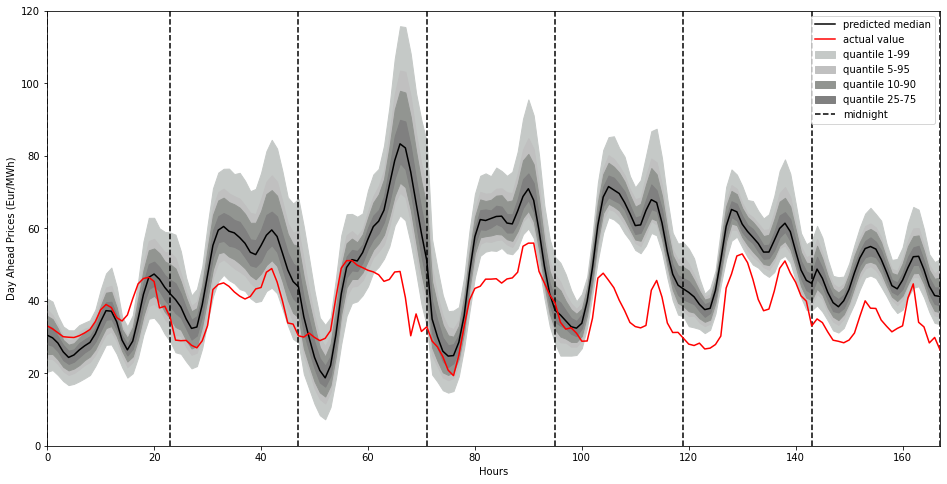

In [ ]:

plt.figure(figsize=(16,8))



x = np.linspace(0, 7*24-1, 7*24)

plt.fill_between(x, pred_1[0:7*24], pred_99[0:7*24], color='#C5C9C7', label='quantile 1-99')
plt.fill_between(x, pred_5[0:7*24], pred_95[0:7*24], color='#C0C0C0', label='quantile 5-95')
plt.fill_between(x, pred_10[0:7*24], pred_90[0:7*24], color='#929591', label='quantile 10-90')
plt.fill_between(x, pred_25[0:7*24], pred_75[0:7*24], color='#808080', label='quantile 25-75')
plt.plot(pred_50[0:7*24], color='black', label='predicted median')
plt.plot(y_test_retransformed_flattened[0:7*24], color='red', label='actual value')
plt.vlines(np.arange(23, 167+24, 24), 0, 120, linestyles='dashed', label='midnight')
plt.vlines(0, 0, 120, linestyles='dashed')
plt.xlabel("Hours")
plt.ylabel("Day Ahead Prices (Eur/MWh)")
plt.ylim(0, 120)
plt.xlim(0, 167)
plt.legend()
plt.plot()




### Mean Squared Error of entire test month

In [ ]:

m = tf.keras.metrics.MeanSquaredError()
m.update_state(y_test_retransformed_flattened, pred_50)
print("mean squared error with median:")
mse = float(m.result())
print(f'€{round(mse, 2)}')

mean squared error with median:
€141.27


### Total quantile loss per hour

In [ ]:
# print(y_test_retransformed.shape)
# print(y_pred_retransformed.shape)
total_loss_daily = 0
quantile_order = [0.1, 0.5, 0.9, 0.01, 0.99, 0.05, 0.95, 0.25, 0.75]

for i in range(9):
  quantile_prediction = y_pred_retransformed[i, :, :]
  loss = np.sum(tf.cast(q_loss(y_pred_retransformed[i, :, :], y_test_retransformed[:, :, 0], quantile_order[i]), dtype=np.float32))/31
  total_loss_daily += loss

hourly_total_quantile_loss = np.round(total_loss_daily/24, 2)
print(f'hourly total quantile loss of the 1st, 5th, 10th, 25th, 75th, 90th, 95th and 99th quantile combined:')
print('hourly_total_quantile_loss')


NameError: ignored